In [ ]:

# Import necessary libraries
import pandas as pd
import numpy as np
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully")


Libraries imported successfully


In [ ]:

# Step 1: Load the rule_hybrid_designs.csv and examine the structure
rule_hybrid_df = pd.read_csv('rule_hybrid_designs.csv')

print("Rule-Hybrid library loaded")
print(f"Shape: {rule_hybrid_df.shape}")
print("\nColumn names:")
print(rule_hybrid_df.columns.tolist())
print("\nFirst few rows:")
print(rule_hybrid_df.head(10))


Rule-Hybrid library loaded
Shape: (3138, 6)

Column names:
['Scaffold', 'Parent_Motif', 'Motif', 'Design_Sequence', 'MJ_Score_Raw', 'MJ_Score_Normalized']

First few rows:
  Scaffold Parent_Motif      Motif  \
0     1FNA    MGVVMMLTV  IGVVMMLTV   
1     1TEN    MGVVMMLTV  IGVVMMLTV   
2     2QMT    MGVVMMLTV  IGVVMMLTV   
3     1FNA    MGVVMMLTV  LGVVMMLTV   
4     1TEN    MGVVMMLTV  LGVVMMLTV   
5     2QMT    MGVVMMLTV  LGVVMMLTV   
6     1FNA    MGVVMMLTV  VGVVMMLTV   
7     1TEN    MGVVMMLTV  VGVVMMLTV   
8     2QMT    MGVVMMLTV  VGVVMMLTV   
9     1FNA    MGVVMMLTV  MGIVMMLTV   

                                     Design_Sequence  MJ_Score_Raw  \
0  MQYKLILNGKTLKGETTTEAIGVVMMLTVVDAATAEKVFKQYANDN...      -4630.13   
1       GSDTITNATIIGVVMMLTVKVQAPDYNVTAKAIGSLRAQACKVV      -4630.13   
2  MIEKKIEKLEEHLGLIGVVMMLTVAESVEQVLSLKDAADLAVVQKT...      -4630.13   
3  MQYKLILNGKTLKGETTTEALGVVMMLTVVDAATAEKVFKQYANDN...      -4661.57   
4       GSDTITNATILGVVMMLTVKVQAPDYNVTAKAIGSLRAQACKVV      -

In [ ]:

# Step 1 continued: Identify the 5 unique 9-mer motifs with best (most negative) raw MJ scores
# Group by motif and get the best score for each (they should be same across scaffolds)

motif_scores = rule_hybrid_df.groupby('Motif')['MJ_Score_Raw'].first().reset_index()
motif_scores_sorted = motif_scores.sort_values('MJ_Score_Raw', ascending=True)

print("Top 10 motifs by raw MJ score:")
print(motif_scores_sorted.head(10))

# Select top 5
top_5_motifs = motif_scores_sorted.head(5)['Motif'].tolist()
print("\n" + "="*60)
print("Top 5 motifs selected for Rule-Hybrid 2.0 generation:")
print("="*60)
for i, motif in enumerate(top_5_motifs, 1):
    score = motif_scores_sorted[motif_scores_sorted['Motif'] == motif]['MJ_Score_Raw'].values[0]
    print(f"{i}. {motif} (MJ Score: {score:.2f})")


Top 10 motifs by raw MJ score:
          Motif  MJ_Score_Raw
1008  VQCVVCVVL      -4713.75
999   VQCVLCVVI      -4713.75
1002  VQCVVCLVI      -4713.75
1005  VQCVVCVLI      -4713.75
996   VQCLVCVVI      -4713.75
207   LQCVVCVVI      -4713.75
968   VKCVVCLVL      -4705.28
944   VKCVLCVVL      -4705.28
983   VKCVVCVLL      -4705.28
911   VKCLVCVVL      -4705.28

Top 5 motifs selected for Rule-Hybrid 2.0 generation:
1. VQCVVCVVL (MJ Score: -4713.75)
2. VQCVLCVVI (MJ Score: -4713.75)
3. VQCVVCLVI (MJ Score: -4713.75)
4. VQCVVCVLI (MJ Score: -4713.75)
5. VQCLVCVVI (MJ Score: -4713.75)


In [ ]:

# Step 2: Define BLOSUM62 matrix for conservative mutations
# BLOSUM62 matrix - we only need values > 0 for conservative mutations

BLOSUM62 = {
    'A': {'A': 4, 'S': 1, 'T': 0, 'V': 0, 'M': -1, 'I': -1, 'L': -1, 'F': -2, 'W': -3, 'Y': -2, 'G': 0, 'P': -1, 'C': 0, 'H': -2, 'K': -1, 'R': -1, 'Q': -1, 'E': -1, 'N': -2, 'D': -2},
    'S': {'A': 1, 'S': 4, 'T': 1, 'V': -2, 'M': -1, 'I': -2, 'L': -2, 'F': -2, 'W': -3, 'Y': -2, 'G': 0, 'P': -1, 'C': -1, 'H': -1, 'K': 0, 'R': -1, 'Q': 0, 'E': 0, 'N': 1, 'D': 0},
    'T': {'A': 0, 'S': 1, 'T': 4, 'V': 0, 'M': -1, 'I': -1, 'L': -1, 'F': -2, 'W': -2, 'Y': -2, 'G': -2, 'P': -1, 'C': -1, 'H': -2, 'K': -1, 'R': -1, 'Q': -1, 'E': -1, 'N': 0, 'D': -1},
    'V': {'A': 0, 'S': -2, 'T': 0, 'V': 4, 'M': 1, 'I': 3, 'L': 1, 'F': -1, 'W': -3, 'Y': -1, 'G': -3, 'P': -2, 'C': -1, 'H': -3, 'K': -2, 'R': -3, 'Q': -2, 'E': -2, 'N': -3, 'D': -3},
    'M': {'A': -1, 'S': -1, 'T': -1, 'V': 1, 'M': 5, 'I': 1, 'L': 2, 'F': 0, 'W': -1, 'Y': -1, 'G': -3, 'P': -2, 'C': -1, 'H': -2, 'K': -1, 'R': -1, 'Q': 0, 'E': -2, 'N': -2, 'D': -3},
    'I': {'A': -1, 'S': -2, 'T': -1, 'V': 3, 'M': 1, 'I': 4, 'L': 2, 'F': 0, 'W': -3, 'Y': -1, 'G': -4, 'P': -3, 'C': -1, 'H': -3, 'K': -3, 'R': -3, 'Q': -3, 'E': -3, 'N': -3, 'D': -3},
    'L': {'A': -1, 'S': -2, 'T': -1, 'V': 1, 'M': 2, 'I': 2, 'L': 4, 'F': 0, 'W': -2, 'Y': -1, 'G': -4, 'P': -3, 'C': -1, 'H': -3, 'K': -2, 'R': -2, 'Q': -2, 'E': -3, 'N': -3, 'D': -4},
    'F': {'A': -2, 'S': -2, 'T': -2, 'V': -1, 'M': 0, 'I': 0, 'L': 0, 'F': 6, 'W': 1, 'Y': 3, 'G': -3, 'P': -4, 'C': -2, 'H': -1, 'K': -3, 'R': -3, 'Q': -3, 'E': -3, 'N': -3, 'D': -3},
    'W': {'A': -3, 'S': -3, 'T': -2, 'V': -3, 'M': -1, 'I': -3, 'L': -2, 'F': 1, 'W': 11, 'Y': 2, 'G': -2, 'P': -4, 'C': -2, 'H': -2, 'K': -3, 'R': -3, 'Q': -2, 'E': -3, 'N': -4, 'D': -4},
    'Y': {'A': -2, 'S': -2, 'T': -2, 'V': -1, 'M': -1, 'I': -1, 'L': -1, 'F': 3, 'W': 2, 'Y': 7, 'G': -3, 'P': -3, 'C': -2, 'H': 2, 'K': -2, 'R': -2, 'Q': -1, 'E': -2, 'N': -2, 'D': -3},
    'G': {'A': 0, 'S': 0, 'T': -2, 'V': -3, 'M': -3, 'I': -4, 'L': -4, 'F': -3, 'W': -2, 'Y': -3, 'G': 6, 'P': -2, 'C': -3, 'H': -2, 'K': -2, 'R': -2, 'Q': -2, 'E': -2, 'N': 0, 'D': -1},
    'P': {'A': -1, 'S': -1, 'T': -1, 'V': -2, 'M': -2, 'I': -3, 'L': -3, 'F': -4, 'W': -4, 'Y': -3, 'G': -2, 'P': 7, 'C': -3, 'H': -2, 'K': -1, 'R': -2, 'Q': -1, 'E': -1, 'N': -2, 'D': -1},
    'C': {'A': 0, 'S': -1, 'T': -1, 'V': -1, 'M': -1, 'I': -1, 'L': -1, 'F': -2, 'W': -2, 'Y': -2, 'G': -3, 'P': -3, 'C': 9, 'H': -3, 'K': -3, 'R': -3, 'Q': -3, 'E': -4, 'N': -3, 'D': -3},
    'H': {'A': -2, 'S': -1, 'T': -2, 'V': -3, 'M': -2, 'I': -3, 'L': -3, 'F': -1, 'W': -2, 'Y': 2, 'G': -2, 'P': -2, 'C': -3, 'H': 8, 'K': -1, 'R': 0, 'Q': 0, 'E': 0, 'N': 1, 'D': -1},
    'K': {'A': -1, 'S': 0, 'T': -1, 'V': -2, 'M': -1, 'I': -3, 'L': -2, 'F': -3, 'W': -3, 'Y': -2, 'G': -2, 'P': -1, 'C': -3, 'H': -1, 'K': 5, 'R': 2, 'Q': 1, 'E': 1, 'N': 0, 'D': -1},
    'R': {'A': -1, 'S': -1, 'T': -1, 'V': -3, 'M': -1, 'I': -3, 'L': -2, 'F': -3, 'W': -3, 'Y': -2, 'G': -2, 'P': -2, 'C': -3, 'H': 0, 'K': 2, 'R': 5, 'Q': 1, 'E': 0, 'N': -1, 'D': -2},
    'Q': {'A': -1, 'S': 0, 'T': -1, 'V': -2, 'M': 0, 'I': -3, 'L': -2, 'F': -3, 'W': -2, 'Y': -1, 'G': -2, 'P': -1, 'C': -3, 'H': 0, 'K': 1, 'R': 1, 'Q': 5, 'E': 2, 'N': 0, 'D': 0},
    'E': {'A': -1, 'S': 0, 'T': -1, 'V': -2, 'M': -2, 'I': -3, 'L': -3, 'F': -3, 'W': -3, 'Y': -2, 'G': -2, 'P': -1, 'C': -4, 'H': 0, 'K': 1, 'R': 0, 'Q': 2, 'E': 5, 'N': 0, 'D': 2},
    'N': {'A': -2, 'S': 1, 'T': 0, 'V': -3, 'M': -2, 'I': -3, 'L': -3, 'F': -3, 'W': -4, 'Y': -2, 'G': 0, 'P': -2, 'C': -3, 'H': 1, 'K': 0, 'R': -1, 'Q': 0, 'E': 0, 'N': 6, 'D': 1},
    'D': {'A': -2, 'S': 0, 'T': -1, 'V': -3, 'M': -3, 'I': -3, 'L': -4, 'F': -3, 'W': -4, 'Y': -3, 'G': -1, 'P': -1, 'C': -3, 'H': -1, 'K': -1, 'R': -2, 'Q': 0, 'E': 2, 'N': 1, 'D': 6},
}

def get_conservative_substitutions(amino_acid):
    """Return list of conservative substitutions (BLOSUM62 > 0) for a given amino acid"""
    if amino_acid not in BLOSUM62:
        return []
    substitutions = [aa for aa, score in BLOSUM62[amino_acid].items() 
                    if score > 0 and aa != amino_acid]
    return substitutions

# Test the function
print("Conservative substitutions for V:", get_conservative_substitutions('V'))
print("Conservative substitutions for C:", get_conservative_substitutions('C'))
print("Conservative substitutions for L:", get_conservative_substitutions('L'))


Conservative substitutions for V: ['M', 'I', 'L']
Conservative substitutions for C: []
Conservative substitutions for L: ['V', 'M', 'I']


In [ ]:

# Step 2 continued: Generate all double mutants for each of the top 5 motifs
# For a 9-mer, we'll generate mutants at all possible position pairs

def generate_double_mutants(parent_motif):
    """Generate all possible double conservative mutants"""
    mutants = []
    sequence_list = list(parent_motif)
    n = len(sequence_list)
    
    # Get all position pairs
    position_pairs = list(combinations(range(n), 2))
    
    for pos1, pos2 in position_pairs:
        aa1 = sequence_list[pos1]
        aa2 = sequence_list[pos2]
        
        # Get conservative substitutions for each position
        subs1 = get_conservative_substitutions(aa1)
        subs2 = get_conservative_substitutions(aa2)
        
        # Generate all combinations of substitutions at these two positions
        for sub1 in subs1:
            for sub2 in subs2:
                new_sequence = sequence_list.copy()
                new_sequence[pos1] = sub1
                new_sequence[pos2] = sub2
                mutant = ''.join(new_sequence)
                mutants.append({
                    'Parent_Motif': parent_motif,
                    'Mutant': mutant,
                    'Positions': f"{pos1+1},{pos2+1}",
                    'Mutations': f"{aa1}{pos1+1}{sub1},{aa2}{pos2+1}{sub2}"
                })
    
    return mutants

# Generate double mutants for all top 5 motifs
all_double_mutants = []

print("Generating double mutants for each parent motif:")
print("="*60)

for i, parent in enumerate(top_5_motifs, 1):
    mutants = generate_double_mutants(parent)
    all_double_mutants.extend(mutants)
    print(f"{i}. {parent}: Generated {len(mutants)} double mutants")

# Convert to DataFrame
double_mutants_df = pd.DataFrame(all_double_mutants)

print("\n" + "="*60)
print(f"Total unique double mutants generated: {len(double_mutants_df)}")
print("\nFirst 10 double mutants:")
print(double_mutants_df.head(10))


Generating double mutants for each parent motif:
1. VQCVVCVVL: Generated 189 double mutants
2. VQCVLCVVI: Generated 189 double mutants
3. VQCVVCLVI: Generated 189 double mutants
4. VQCVVCVLI: Generated 189 double mutants
5. VQCLVCVVI: Generated 189 double mutants

Total unique double mutants generated: 945

First 10 double mutants:
  Parent_Motif     Mutant Positions Mutations
0    VQCVVCVVL  MKCVVCVVL       1,2   V1M,Q2K
1    VQCVVCVVL  MRCVVCVVL       1,2   V1M,Q2R
2    VQCVVCVVL  MECVVCVVL       1,2   V1M,Q2E
3    VQCVVCVVL  IKCVVCVVL       1,2   V1I,Q2K
4    VQCVVCVVL  IRCVVCVVL       1,2   V1I,Q2R
5    VQCVVCVVL  IECVVCVVL       1,2   V1I,Q2E
6    VQCVVCVVL  LKCVVCVVL       1,2   V1L,Q2K
7    VQCVVCVVL  LRCVVCVVL       1,2   V1L,Q2R
8    VQCVVCVVL  LECVVCVVL       1,2   V1L,Q2E
9    VQCVVCVVL  MQCMVCVVL       1,4   V1M,V4M


In [ ]:

# Step 3: Graft each motif onto the three standard scaffolds (1FNA, 1TEN, 2QMT)
# Based on the rule_hybrid_designs.csv, the scaffolds appear to be:
# 1FNA: MQYKLILNGKTLKGETTTEA[MOTIF]VDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
# 1TEN: GSDTITNATI[MOTIF]KVQAPDYNVTAKAIGSLRAQACKVV
# 2QMT: MIEKKIEKLEEHLGL[MOTIF]AESVEQVLSLKDAADLAVVQKTLAEAQHLPQPTQSL

# Define scaffold templates (extracted from the rule_hybrid_designs.csv)
scaffolds = {
    '1FNA': {
        'prefix': 'MQYKLILNGKTLKGETTTEA',
        'suffix': 'VDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'
    },
    '1TEN': {
        'prefix': 'GSDTITNATI',
        'suffix': 'KVQAPDYNVTAKAIGSLRAQACKVV'
    },
    '2QMT': {
        'prefix': 'MIEKKIEKLEEHLGL',
        'suffix': 'AESVEQVLSLKDAADLAVVQKTLAEAQHLPQPTQSL'
    }
}

def graft_motif_to_scaffolds(motif):
    """Graft a motif onto all three scaffolds"""
    designs = []
    for scaffold_name, scaffold_info in scaffolds.items():
        full_sequence = scaffold_info['prefix'] + motif + scaffold_info['suffix']
        designs.append({
            'Scaffold': scaffold_name,
            'Motif': motif,
            'Design_Sequence': full_sequence
        })
    return designs

# Generate all designs by grafting each double mutant onto all scaffolds
all_designs = []

for idx, row in double_mutants_df.iterrows():
    motif = row['Mutant']
    parent = row['Parent_Motif']
    mutations = row['Mutations']
    
    # Graft onto scaffolds
    designs = graft_motif_to_scaffolds(motif)
    
    # Add metadata
    for design in designs:
        design['Parent_Motif'] = parent
        design['Mutations'] = mutations
        all_designs.append(design)

designs_df = pd.DataFrame(all_designs)

print(f"Total designs generated (before novelty filtering): {len(designs_df)}")
print(f"Unique motifs: {designs_df['Motif'].nunique()}")
print("\nFirst few designs:")
print(designs_df.head(10))


Total designs generated (before novelty filtering): 2835
Unique motifs: 696

First few designs:
  Scaffold      Motif                                    Design_Sequence  \
0     1FNA  MKCVVCVVL  MQYKLILNGKTLKGETTTEAMKCVVCVVLVDAATAEKVFKQYANDN...   
1     1TEN  MKCVVCVVL       GSDTITNATIMKCVVCVVLKVQAPDYNVTAKAIGSLRAQACKVV   
2     2QMT  MKCVVCVVL  MIEKKIEKLEEHLGLMKCVVCVVLAESVEQVLSLKDAADLAVVQKT...   
3     1FNA  MRCVVCVVL  MQYKLILNGKTLKGETTTEAMRCVVCVVLVDAATAEKVFKQYANDN...   
4     1TEN  MRCVVCVVL       GSDTITNATIMRCVVCVVLKVQAPDYNVTAKAIGSLRAQACKVV   
5     2QMT  MRCVVCVVL  MIEKKIEKLEEHLGLMRCVVCVVLAESVEQVLSLKDAADLAVVQKT...   
6     1FNA  MECVVCVVL  MQYKLILNGKTLKGETTTEAMECVVCVVLVDAATAEKVFKQYANDN...   
7     1TEN  MECVVCVVL       GSDTITNATIMECVVCVVLKVQAPDYNVTAKAIGSLRAQACKVV   
8     2QMT  MECVVCVVL  MIEKKIEKLEEHLGLMECVVCVVLAESVEQVLSLKDAADLAVVQKT...   
9     1FNA  IKCVVCVVL  MQYKLILNGKTLKGETTTEAIKCVVCVVLVDAATAEKVFKQYANDN...   

  Parent_Motif Mutations  
0    VQCVVCVVL   V1M,Q2K  
1    VQCVVCVV

In [ ]:

# Step 4: Novelty filtering - check for 10-mer subsequences against known sequences
# Load the known sequences

from Bio import SeqIO

# Load known binders
known_sequences = []
with open('known_niv_binders_full.fasta', 'r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        known_sequences.append(str(record.seq))

# Load CDR libraries
cdr_competitive = pd.read_csv('cdr_library_summary.csv')
known_sequences.extend(cdr_competitive['Sequence'].tolist())

cdr_allosteric = pd.read_csv('allosteric_cdr_library.csv')
known_sequences.extend(cdr_allosteric['Sequence'].tolist())

print(f"Total known sequences loaded: {len(known_sequences)}")
print(f"Unique known sequences: {len(set(known_sequences))}")

# Generate all 10-mers from known sequences
known_10mers = set()
for seq in known_sequences:
    for i in range(len(seq) - 9):
        known_10mers.add(seq[i:i+10])

print(f"Total unique 10-mers from known sequences: {len(known_10mers)}")


Total known sequences loaded: 39
Unique known sequences: 36
Total unique 10-mers from known sequences: 913


In [ ]:

# Step 4 continued: Apply novelty filter to all designs

def has_known_10mer(sequence, known_10mers):
    """Check if a sequence contains any known 10-mer"""
    for i in range(len(sequence) - 9):
        if sequence[i:i+10] in known_10mers:
            return True
    return False

# Apply novelty filter
print("Applying novelty filter...")
designs_df['Is_Novel'] = designs_df['Design_Sequence'].apply(
    lambda seq: not has_known_10mer(seq, known_10mers)
)

# Filter for novel designs only
novel_designs_df = designs_df[designs_df['Is_Novel']].copy()

print(f"\nNovelty filtering results:")
print(f"  Designs before filtering: {len(designs_df)}")
print(f"  Designs after filtering: {len(novel_designs_df)}")
print(f"  Designs rejected: {len(designs_df) - len(novel_designs_df)}")
print(f"  Pass rate: {len(novel_designs_df)/len(designs_df)*100:.1f}%")
print(f"\nUnique novel motifs: {novel_designs_df['Motif'].nunique()}")


Applying novelty filter...

Novelty filtering results:
  Designs before filtering: 2835
  Designs after filtering: 2835
  Designs rejected: 0
  Pass rate: 100.0%

Unique novel motifs: 696


In [ ]:

# Step 5: Score all novel designs using raw MJ interaction score
# Define the 111-residue allosteric epitope
allosteric_epitope = "LAKIGEIGKVSLIDSSTTIPNILGSKISSTSINENVNKCKFTLPPLKIHECNISCPRTGVGLPNNICLQSYTLPVVGQSKEVLDRGSLFMQLGQPDVLTVNDRINIKKNKE"

print(f"Allosteric epitope length: {len(allosteric_epitope)}")
print(f"Allosteric epitope: {allosteric_epitope}")


Allosteric epitope length: 111
Allosteric epitope: LAKIGEIGKVSLIDSSTTIPNILGSKISSTSINENVNKCKFTLPPLKIHECNISCPRTGVGLPNNICLQSYTLPVVGQSKEVLDRGSLFMQLGQPDVLTVNDRINIKKNKE


In [ ]:

# Step 5 continued: Define Miyazawa-Jernigan scoring function
# MJ potential matrix (symmetric, values in units of kT)

MJ_MATRIX = {
    ('C', 'C'): -5.44, ('C', 'M'): -5.46, ('C', 'F'): -5.80, ('C', 'I'): -5.50,
    ('C', 'L'): -5.83, ('C', 'V'): -5.50, ('C', 'W'): -5.50, ('C', 'Y'): -4.16,
    ('C', 'A'): -4.13, ('C', 'G'): -4.16, ('C', 'T'): -4.96, ('C', 'S'): -3.73,
    ('C', 'N'): -2.59, ('C', 'Q'): -3.37, ('C', 'D'): -2.85, ('C', 'E'): -2.27,
    ('C', 'H'): -3.60, ('C', 'R'): -2.57, ('C', 'K'): -1.95, ('C', 'P'): -3.07,
    ('M', 'M'): -5.46, ('M', 'F'): -5.68, ('M', 'I'): -5.32, ('M', 'L'): -5.55,
    ('M', 'V'): -5.32, ('M', 'W'): -5.55, ('M', 'Y'): -4.91, ('M', 'A'): -3.94,
    ('M', 'G'): -3.87, ('M', 'T'): -4.29, ('M', 'S'): -3.56, ('M', 'N'): -2.95,
    ('M', 'Q'): -3.30, ('M', 'D'): -2.57, ('M', 'E'): -2.89, ('M', 'H'): -3.98,
    ('M', 'R'): -3.12, ('M', 'K'): -2.48, ('M', 'P'): -3.45,
    ('F', 'F'): -6.84, ('F', 'I'): -5.88, ('F', 'L'): -5.89, ('F', 'V'): -5.66,
    ('F', 'W'): -6.16, ('F', 'Y'): -5.66, ('F', 'A'): -4.81, ('F', 'G'): -4.13,
    ('F', 'T'): -4.28, ('F', 'S'): -3.75, ('F', 'N'): -3.48, ('F', 'Q'): -4.10,
    ('F', 'D'): -3.48, ('F', 'E'): -3.56, ('F', 'H'): -4.77, ('F', 'R'): -3.98,
    ('F', 'K'): -3.36, ('F', 'P'): -4.03,
    ('I', 'I'): -5.50, ('I', 'L'): -5.61, ('I', 'V'): -5.29, ('I', 'W'): -5.78,
    ('I', 'Y'): -4.72, ('I', 'A'): -4.58, ('I', 'G'): -4.16, ('I', 'T'): -4.03,
    ('I', 'S'): -3.52, ('I', 'N'): -3.24, ('I', 'Q'): -3.67, ('I', 'D'): -3.17,
    ('I', 'E'): -3.27, ('I', 'H'): -4.14, ('I', 'R'): -3.63, ('I', 'K'): -3.01,
    ('I', 'P'): -3.76,
    ('L', 'L'): -5.68, ('L', 'V'): -5.32, ('L', 'W'): -5.80, ('L', 'Y'): -4.91,
    ('L', 'A'): -4.91, ('L', 'G'): -4.16, ('L', 'T'): -4.34, ('L', 'S'): -3.60,
    ('L', 'N'): -3.37, ('L', 'Q'): -3.98, ('L', 'D'): -3.40, ('L', 'E'): -3.59,
    ('L', 'H'): -4.25, ('L', 'R'): -3.98, ('L', 'K'): -3.37, ('L', 'P'): -3.98,
    ('V', 'V'): -5.18, ('V', 'W'): -5.18, ('V', 'Y'): -4.62, ('V', 'A'): -4.04,
    ('V', 'G'): -3.63, ('V', 'T'): -4.03, ('V', 'S'): -3.37, ('V', 'N'): -3.10,
    ('V', 'Q'): -3.48, ('V', 'D'): -2.88, ('V', 'E'): -3.07, ('V', 'H'): -3.98,
    ('V', 'R'): -3.32, ('V', 'K'): -2.69, ('V', 'P'): -3.32,
    ('W', 'W'): -5.83, ('W', 'Y'): -5.18, ('W', 'A'): -4.25, ('W', 'G'): -4.07,
    ('W', 'T'): -4.88, ('W', 'S'): -3.98, ('W', 'N'): -4.36, ('W', 'Q'): -4.88,
    ('W', 'D'): -4.25, ('W', 'E'): -3.98, ('W', 'H'): -3.98, ('W', 'R'): -3.41,
    ('W', 'K'): -3.17, ('W', 'P'): -4.25,
    ('Y', 'Y'): -5.66, ('Y', 'A'): -3.36, ('Y', 'G'): -3.73, ('Y', 'T'): -3.94,
    ('Y', 'S'): -3.36, ('Y', 'N'): -2.76, ('Y', 'Q'): -3.73, ('Y', 'D'): -3.27,
    ('Y', 'E'): -3.01, ('Y', 'H'): -3.52, ('Y', 'R'): -3.60, ('Y', 'K'): -2.78,
    ('Y', 'P'): -3.19,
    ('A', 'A'): -3.24, ('A', 'G'): -3.34, ('A', 'T'): -2.85, ('A', 'S'): -2.59,
    ('A', 'N'): -2.24, ('A', 'Q'): -2.32, ('A', 'D'): -2.41, ('A', 'E'): -2.62,
    ('A', 'H'): -2.78, ('A', 'R'): -2.57, ('A', 'K'): -2.24, ('A', 'P'): -2.62,
    ('G', 'G'): -3.16, ('G', 'T'): -2.85, ('G', 'S'): -2.39, ('G', 'N'): -2.48,
    ('G', 'Q'): -2.85, ('G', 'D'): -2.59, ('G', 'E'): -2.39, ('G', 'H'): -3.07,
    ('G', 'R'): -2.24, ('G', 'K'): -2.32, ('G', 'P'): -2.72,
    ('T', 'T'): -3.40, ('T', 'S'): -2.57, ('T', 'N'): -2.29, ('T', 'Q'): -2.78,
    ('T', 'D'): -2.85, ('T', 'E'): -2.59, ('T', 'H'): -2.85, ('T', 'R'): -2.27,
    ('T', 'K'): -2.29, ('T', 'P'): -2.41,
    ('S', 'S'): -2.85, ('S', 'N'): -2.13, ('S', 'Q'): -2.57, ('S', 'D'): -2.29,
    ('S', 'E'): -2.27, ('S', 'H'): -2.85, ('S', 'R'): -2.19, ('S', 'K'): -1.95,
    ('S', 'P'): -1.57,
    ('N', 'N'): -2.41, ('N', 'Q'): -2.48, ('N', 'D'): -2.62, ('N', 'E'): -1.88,
    ('N', 'H'): -3.07, ('N', 'R'): -2.29, ('N', 'K'): -1.88, ('N', 'P'): -1.53,
    ('Q', 'Q'): -3.17, ('Q', 'D'): -2.62, ('Q', 'E'): -2.51, ('Q', 'H'): -3.07,
    ('Q', 'R'): -2.57, ('Q', 'K'): -1.84, ('Q', 'P'): -2.76,
    ('D', 'D'): -2.41, ('D', 'E'): -2.13, ('D', 'H'): -2.32, ('D', 'R'): -2.29,
    ('D', 'K'): -1.68, ('D', 'P'): -1.98,
    ('E', 'E'): -2.67, ('E', 'H'): -2.51, ('E', 'R'): -2.27, ('E', 'K'): -1.80,
    ('E', 'P'): -2.29,
    ('H', 'H'): -3.05, ('H', 'R'): -2.78, ('H', 'K'): -2.32, ('H', 'P'): -2.39,
    ('R', 'R'): -2.57, ('R', 'K'): -1.80, ('R', 'P'): -2.19,
    ('K', 'K'): -1.29, ('K', 'P'): -1.29,
    ('P', 'P'): -1.75
}

def calculate_mj_score(motif, epitope):
    """Calculate raw MJ interaction score between motif and epitope"""
    score = 0.0
    for aa1 in motif:
        for aa2 in epitope:
            # MJ matrix is symmetric
            pair = tuple(sorted([aa1, aa2]))
            if pair in MJ_MATRIX:
                score += MJ_MATRIX[pair]
    return score

# Test the function on one of the parent motifs
test_motif = top_5_motifs[0]
test_score = calculate_mj_score(test_motif, allosteric_epitope)
print(f"Test calculation:")
print(f"Motif: {test_motif}")
print(f"Raw MJ Score: {test_score:.2f}")

# Compare with expected score from rule_hybrid_designs.csv
expected_score = rule_hybrid_df[rule_hybrid_df['Motif'] == test_motif]['MJ_Score_Raw'].values[0]
print(f"Expected score from file: {expected_score:.2f}")
print(f"Difference: {abs(test_score - expected_score):.2f}")


Test calculation:
Motif: VQCVVCVVL
Raw MJ Score: -2517.44
Expected score from file: -4713.75
Difference: 2196.31


In [ ]:

# There's a discrepancy - let me check the calculation more carefully
# The issue is that we need to look at the full design sequence, not just the motif
# Let me verify by checking a complete design from rule_hybrid_designs.csv

# Get one example from rule_hybrid_designs
example_row = rule_hybrid_df[rule_hybrid_df['Motif'] == test_motif].iloc[0]
example_design = example_row['Design_Sequence']
example_score = example_row['MJ_Score_Raw']

print(f"Example design from rule_hybrid_designs.csv:")
print(f"Scaffold: {example_row['Scaffold']}")
print(f"Motif: {example_row['Motif']}")
print(f"Design sequence: {example_design}")
print(f"Reported MJ Score: {example_score:.2f}")

# Try calculating score between full design and epitope
full_design_score = calculate_mj_score(example_design, allosteric_epitope)
print(f"\nMJ score (full design vs epitope): {full_design_score:.2f}")

# Try calculating score between motif and epitope only
motif_only_score = calculate_mj_score(test_motif, allosteric_epitope)
print(f"MJ score (motif only vs epitope): {motif_only_score:.2f}")


Example design from rule_hybrid_designs.csv:
Scaffold: 1FNA
Motif: VQCVVCVVL
Design sequence: MQYKLILNGKTLKGETTTEAVQCVVCVVLVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Reported MJ Score: -4713.75

MJ score (full design vs epitope): -12837.00
MJ score (motif only vs epitope): -2517.44


In [ ]:

# I see the issue - the score in rule_hybrid_designs.csv is for the full design, not just the motif
# But according to the objective, we should calculate "the raw MJ interaction score between 
# the 9-mer motif and the 111-residue allosteric epitope sequence"
# Let me verify this is what was done in the original analysis by checking the normalized scores

# The objective states: "Score all novel designs by calculating the raw MJ interaction score 
# between the 9-mer motif and the 111-residue allosteric epitope sequence"

# Let me recalculate for the parent motifs to understand the scoring properly
print("Verifying scoring method - comparing motif-only vs full-design scoring:")
print("="*70)

for motif in top_5_motifs[:3]:
    # Get row from rule_hybrid
    row = rule_hybrid_df[rule_hybrid_df['Motif'] == motif].iloc[0]
    
    # Calculate both ways
    motif_score = calculate_mj_score(motif, allosteric_epitope)
    full_score = calculate_mj_score(row['Design_Sequence'], allosteric_epitope)
    
    print(f"\nMotif: {motif}")
    print(f"  Reported MJ_Score_Raw: {row['MJ_Score_Raw']:.2f}")
    print(f"  Calculated (motif only): {motif_score:.2f}")
    print(f"  Calculated (full design): {full_score:.2f}")
    print(f"  Match with reported: {'Motif' if abs(motif_score - row['MJ_Score_Raw']) < 1 else 'Full' if abs(full_score - row['MJ_Score_Raw']) < 1 else 'Neither'}")


Verifying scoring method - comparing motif-only vs full-design scoring:

Motif: VQCVVCVVL
  Reported MJ_Score_Raw: -4713.75
  Calculated (motif only): -2517.44
  Calculated (full design): -12837.00
  Match with reported: Neither

Motif: VQCVLCVVI
  Reported MJ_Score_Raw: -4713.75
  Calculated (motif only): -2700.86
  Calculated (full design): -13020.42
  Match with reported: Neither

Motif: VQCVVCLVI
  Reported MJ_Score_Raw: -4713.75
  Calculated (motif only): -2700.86
  Calculated (full design): -13020.42
  Match with reported: Neither


In [ ]:

# The scores don't match either way. Let me check if maybe the scoring is done differently
# Let me look at the MJ_Score_Normalized column to understand the relationship

print("Examining the relationship between raw and normalized scores:")
print("="*70)

# Get a sample of different motifs and their scores
sample_motifs = rule_hybrid_df.groupby('Motif').first().reset_index().head(10)

for idx, row in sample_motifs.iterrows():
    motif = row['Motif']
    raw = row['MJ_Score_Raw']
    normalized = row['MJ_Score_Normalized']
    
    # Calculate what we get
    calc_motif = calculate_mj_score(motif, allosteric_epitope)
    
    print(f"\nMotif: {motif}")
    print(f"  Reported Raw: {raw:.2f}, Normalized: {normalized:.2f}")
    print(f"  Calculated (motif-epitope): {calc_motif:.2f}")
    print(f"  Ratio (reported/calculated): {raw/calc_motif:.2f}" if calc_motif != 0 else "  N/A")


Examining the relationship between raw and normalized scores:

Motif: ICIIDCMVK
  Reported Raw: -4513.53, Normalized: -231.46
  Calculated (motif-epitope): -2696.67
  Ratio (reported/calculated): 1.67

Motif: ICILDCIVK
  Reported Raw: -4543.31, Normalized: -232.99
  Calculated (motif-epitope): -2853.95
  Ratio (reported/calculated): 1.59

Motif: ICILDCLVK
  Reported Raw: -4574.75, Normalized: -234.60
  Calculated (motif-epitope): -2835.96
  Ratio (reported/calculated): 1.61

Motif: ICILDCMIK
  Reported Raw: -4544.97, Normalized: -233.08
  Calculated (motif-epitope): -2862.10
  Ratio (reported/calculated): 1.59

Motif: ICILDCMLK
  Reported Raw: -4576.41, Normalized: -234.69
  Calculated (motif-epitope): -2844.11
  Ratio (reported/calculated): 1.61

Motif: ICILDCMMK
  Reported Raw: -4546.63, Normalized: -233.16
  Calculated (motif-epitope): -2686.83
  Ratio (reported/calculated): 1.69

Motif: ICILDCMVE
  Reported Raw: -4545.08, Normalized: -233.08
  Calculated (motif-epitope): -2644.19
 

In [ ]:

# The ratio is not constant, suggesting something more complex is happening
# However, the objective clearly states: "Score all novel designs by calculating the raw MJ 
# interaction score between the 9-mer motif and the 111-residue allosteric epitope sequence"
# I will follow the objective as stated and use motif-only scoring

# Additionally, for comparison purposes, I need to recalculate the parent library using the same method
# Let me check if there are duplicates in the motif scores (same motif, different scaffold)

print("Checking consistency of scoring across scaffolds in rule_hybrid_designs.csv:")
print("="*70)

# For a few motifs, check if the score is the same across all scaffolds
for motif in top_5_motifs[:2]:
    subset = rule_hybrid_df[rule_hybrid_df['Motif'] == motif]
    print(f"\nMotif: {motif}")
    print(subset[['Scaffold', 'MJ_Score_Raw', 'MJ_Score_Normalized']])
    print(f"  All raw scores identical? {subset['MJ_Score_Raw'].nunique() == 1}")


Checking consistency of scoring across scaffolds in rule_hybrid_designs.csv:

Motif: VQCVVCVVL
     Scaffold  MJ_Score_Raw  MJ_Score_Normalized
2022     1FNA      -4713.75          -241.730769
2023     1TEN      -4713.75          -241.730769
2024     2QMT      -4713.75          -241.730769
  All raw scores identical? True

Motif: VQCVLCVVI
     Scaffold  MJ_Score_Raw  MJ_Score_Normalized
1944     1FNA      -4713.75          -241.730769
1945     1TEN      -4713.75          -241.730769
1946     2QMT      -4713.75          -241.730769
  All raw scores identical? True


In [ ]:

# I notice the scores are consistent across scaffolds but don't match my calculation
# Looking at the dataset description, it states: "a scoring discrepancy exists for top 
# allosteric designs: the Refined_MJ_Score is not replicable by a standard pairwise MJ 
# calculation, suggesting the original method used additional structural or distance-based information"

# Since the objective explicitly states to calculate "the raw MJ interaction score between 
# the 9-mer motif and the 111-residue allosteric epitope sequence", I will proceed with 
# motif-only scoring as specified in the objective.

# For statistical comparison, I'll recalculate all scores from rule_hybrid_designs.csv 
# using the same method to ensure fair comparison

print("Proceeding with motif-only scoring as specified in the objective")
print("="*70)

# Calculate MJ scores for all novel designs
print("\nCalculating MJ scores for all Rule-Hybrid 2.0 designs...")
novel_designs_df['MJ_Score_Raw'] = novel_designs_df['Motif'].apply(
    lambda motif: calculate_mj_score(motif, allosteric_epitope)
)

print(f"Scoring complete for {len(novel_designs_df)} designs")
print("\nScore distribution for Rule-Hybrid 2.0:")
print(novel_designs_df['MJ_Score_Raw'].describe())

# Show top 10 designs
top_designs = novel_designs_df.sort_values('MJ_Score_Raw', ascending=True).head(10)
print("\nTop 10 Rule-Hybrid 2.0 designs by MJ score:")
print(top_designs[['Motif', 'Parent_Motif', 'Mutations', 'Scaffold', 'MJ_Score_Raw']])


Proceeding with motif-only scoring as specified in the objective

Calculating MJ scores for all Rule-Hybrid 2.0 designs...


Scoring complete for 2835 designs

Score distribution for Rule-Hybrid 2.0:
count    2835.000000
mean    -2732.532762
std       178.263791
min     -3067.700000
25%     -2874.440000
50%     -2717.160000
75%     -2598.840000
max     -2241.840000
Name: MJ_Score_Raw, dtype: float64

Top 10 Rule-Hybrid 2.0 designs by MJ score:
          Motif Parent_Motif Mutations Scaffold  MJ_Score_Raw
2768  VQCLVCIII    VQCLVCVVI   V7I,V8I     2QMT       -3067.7
2766  VQCLVCIII    VQCLVCVVI   V7I,V8I     1FNA       -3067.7
2767  VQCLVCIII    VQCLVCVVI   V7I,V8I     1TEN       -3067.7
1067  VQCVLCIII    VQCVLCVVI   V7I,V8I     2QMT       -3067.7
1066  VQCVLCIII    VQCVLCVVI   V7I,V8I     1TEN       -3067.7
1065  VQCVLCIII    VQCVLCVVI   V7I,V8I     1FNA       -3067.7
2713  VQCLICVII    VQCLVCVVI   V5I,V8I     1TEN       -3067.7
2686  VQCLICIVI    VQCLVCVVI   V5I,V7I     1TEN       -3067.7
2687  VQCLICIVI    VQCLVCVVI   V5I,V7I     2QMT       -3067.7
2712  VQCLICVII    VQCLVCVVI   V5I,V8I     1FNA       -30

In [ ]:

# Step 6: Save the results to rule_hybrid_2.0_designs.csv

# Organize the columns in a logical order
output_df = novel_designs_df[[
    'Scaffold', 'Parent_Motif', 'Motif', 'Mutations', 
    'Design_Sequence', 'MJ_Score_Raw'
]].copy()

# Sort by MJ score (best scores first)
output_df = output_df.sort_values('MJ_Score_Raw', ascending=True).reset_index(drop=True)

# Save to file
output_df.to_csv('rule_hybrid_2.0_designs.csv', index=False)

print("Results saved to rule_hybrid_2.0_designs.csv")
print(f"\nTotal designs in output file: {len(output_df)}")
print(f"Unique motifs: {output_df['Motif'].nunique()}")
print(f"\nScore range:")
print(f"  Best (most negative): {output_df['MJ_Score_Raw'].min():.2f}")
print(f"  Worst (least negative): {output_df['MJ_Score_Raw'].max():.2f}")
print(f"  Mean: {output_df['MJ_Score_Raw'].mean():.2f}")
print(f"  Median: {output_df['MJ_Score_Raw'].median():.2f}")


Results saved to rule_hybrid_2.0_designs.csv

Total designs in output file: 2835
Unique motifs: 696

Score range:
  Best (most negative): -3067.70
  Worst (least negative): -2241.84
  Mean: -2732.53
  Median: -2717.16


In [ ]:

# Step 7: Statistical comparison with the first-generation Rule-Hybrid library
# Recalculate scores for rule_hybrid_designs.csv using the same motif-only method

print("Recalculating scores for Rule-Hybrid 1.0 library using motif-only scoring...")
print("="*70)

# Calculate motif-only MJ scores for the original library
rule_hybrid_df['MJ_Score_Motif_Only'] = rule_hybrid_df['Motif'].apply(
    lambda motif: calculate_mj_score(motif, allosteric_epitope)
)

print(f"\nRule-Hybrid 1.0 library:")
print(f"  Total designs: {len(rule_hybrid_df)}")
print(f"  Unique motifs: {rule_hybrid_df['Motif'].nunique()}")

print("\nScore distribution for Rule-Hybrid 1.0 (motif-only scoring):")
print(rule_hybrid_df['MJ_Score_Motif_Only'].describe())

print("\nScore distribution for Rule-Hybrid 2.0 (motif-only scoring):")
print(novel_designs_df['MJ_Score_Raw'].describe())

# Show mean comparison
rh1_mean = rule_hybrid_df['MJ_Score_Motif_Only'].mean()
rh2_mean = novel_designs_df['MJ_Score_Raw'].mean()
improvement = rh2_mean - rh1_mean

print("\n" + "="*70)
print("MEAN SCORE COMPARISON:")
print("="*70)
print(f"Rule-Hybrid 1.0 mean: {rh1_mean:.2f}")
print(f"Rule-Hybrid 2.0 mean: {rh2_mean:.2f}")
print(f"Difference: {improvement:.2f} (negative = better for 2.0)")


Recalculating scores for Rule-Hybrid 1.0 library using motif-only scoring...



Rule-Hybrid 1.0 library:
  Total designs: 3138
  Unique motifs: 1046

Score distribution for Rule-Hybrid 1.0 (motif-only scoring):
count    3138.000000
mean    -2504.069818
std       230.445671
min     -3028.780000
25%     -2673.500000
50%     -2514.500000
75%     -2352.010000
max     -1861.060000
Name: MJ_Score_Motif_Only, dtype: float64

Score distribution for Rule-Hybrid 2.0 (motif-only scoring):
count    2835.000000
mean    -2732.532762
std       178.263791
min     -3067.700000
25%     -2874.440000
50%     -2717.160000
75%     -2598.840000
max     -2241.840000
Name: MJ_Score_Raw, dtype: float64

MEAN SCORE COMPARISON:
Rule-Hybrid 1.0 mean: -2504.07
Rule-Hybrid 2.0 mean: -2732.53
Difference: -228.46 (negative = better for 2.0)


In [ ]:

# Step 7 continued: Perform Mann-Whitney U test to determine statistical significance
from scipy.stats import mannwhitneyu

# Get score distributions
rh1_scores = rule_hybrid_df['MJ_Score_Motif_Only'].values
rh2_scores = novel_designs_df['MJ_Score_Raw'].values

# Perform Mann-Whitney U test (two-tailed)
# H0: The distributions are the same
# H1: The distributions differ
statistic, p_value = mannwhitneyu(rh2_scores, rh1_scores, alternative='two-sided')

print("="*70)
print("MANN-WHITNEY U TEST RESULTS")
print("="*70)
print(f"Test statistic: {statistic:.2f}")
print(f"P-value: {p_value:.2e}")
print(f"Significance level: α = 0.05")
print(f"Result: {'Statistically significant' if p_value < 0.05 else 'Not statistically significant'}")

# Also perform one-sided test to specifically test if RH2.0 is better (more negative)
statistic_less, p_value_less = mannwhitneyu(rh2_scores, rh1_scores, alternative='less')
print(f"\nOne-sided test (RH2.0 < RH1.0, i.e., RH2.0 more negative/better):")
print(f"P-value: {p_value_less:.2e}")
print(f"Result: {'RH2.0 is significantly better' if p_value_less < 0.05 else 'RH2.0 is not significantly better'}")

# Calculate effect size (Cohen's d)
mean_diff = rh2_mean - rh1_mean
pooled_std = np.sqrt((np.std(rh2_scores, ddof=1)**2 + np.std(rh1_scores, ddof=1)**2) / 2)
cohens_d = mean_diff / pooled_std

print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")
print(f"Interpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("Small effect")
elif abs(cohens_d) < 0.5:
    print("Small to medium effect")
elif abs(cohens_d) < 0.8:
    print("Medium to large effect")
else:
    print("Large effect")


MANN-WHITNEY U TEST RESULTS
Test statistic: 1930036.50
P-value: 0.00e+00
Significance level: α = 0.05
Result: Statistically significant

One-sided test (RH2.0 < RH1.0, i.e., RH2.0 more negative/better):
P-value: 0.00e+00
Result: RH2.0 is significantly better

Effect size (Cohen's d): -1.109
Interpretation: Large effect


Figure saved as rule_hybrid_comparison.png


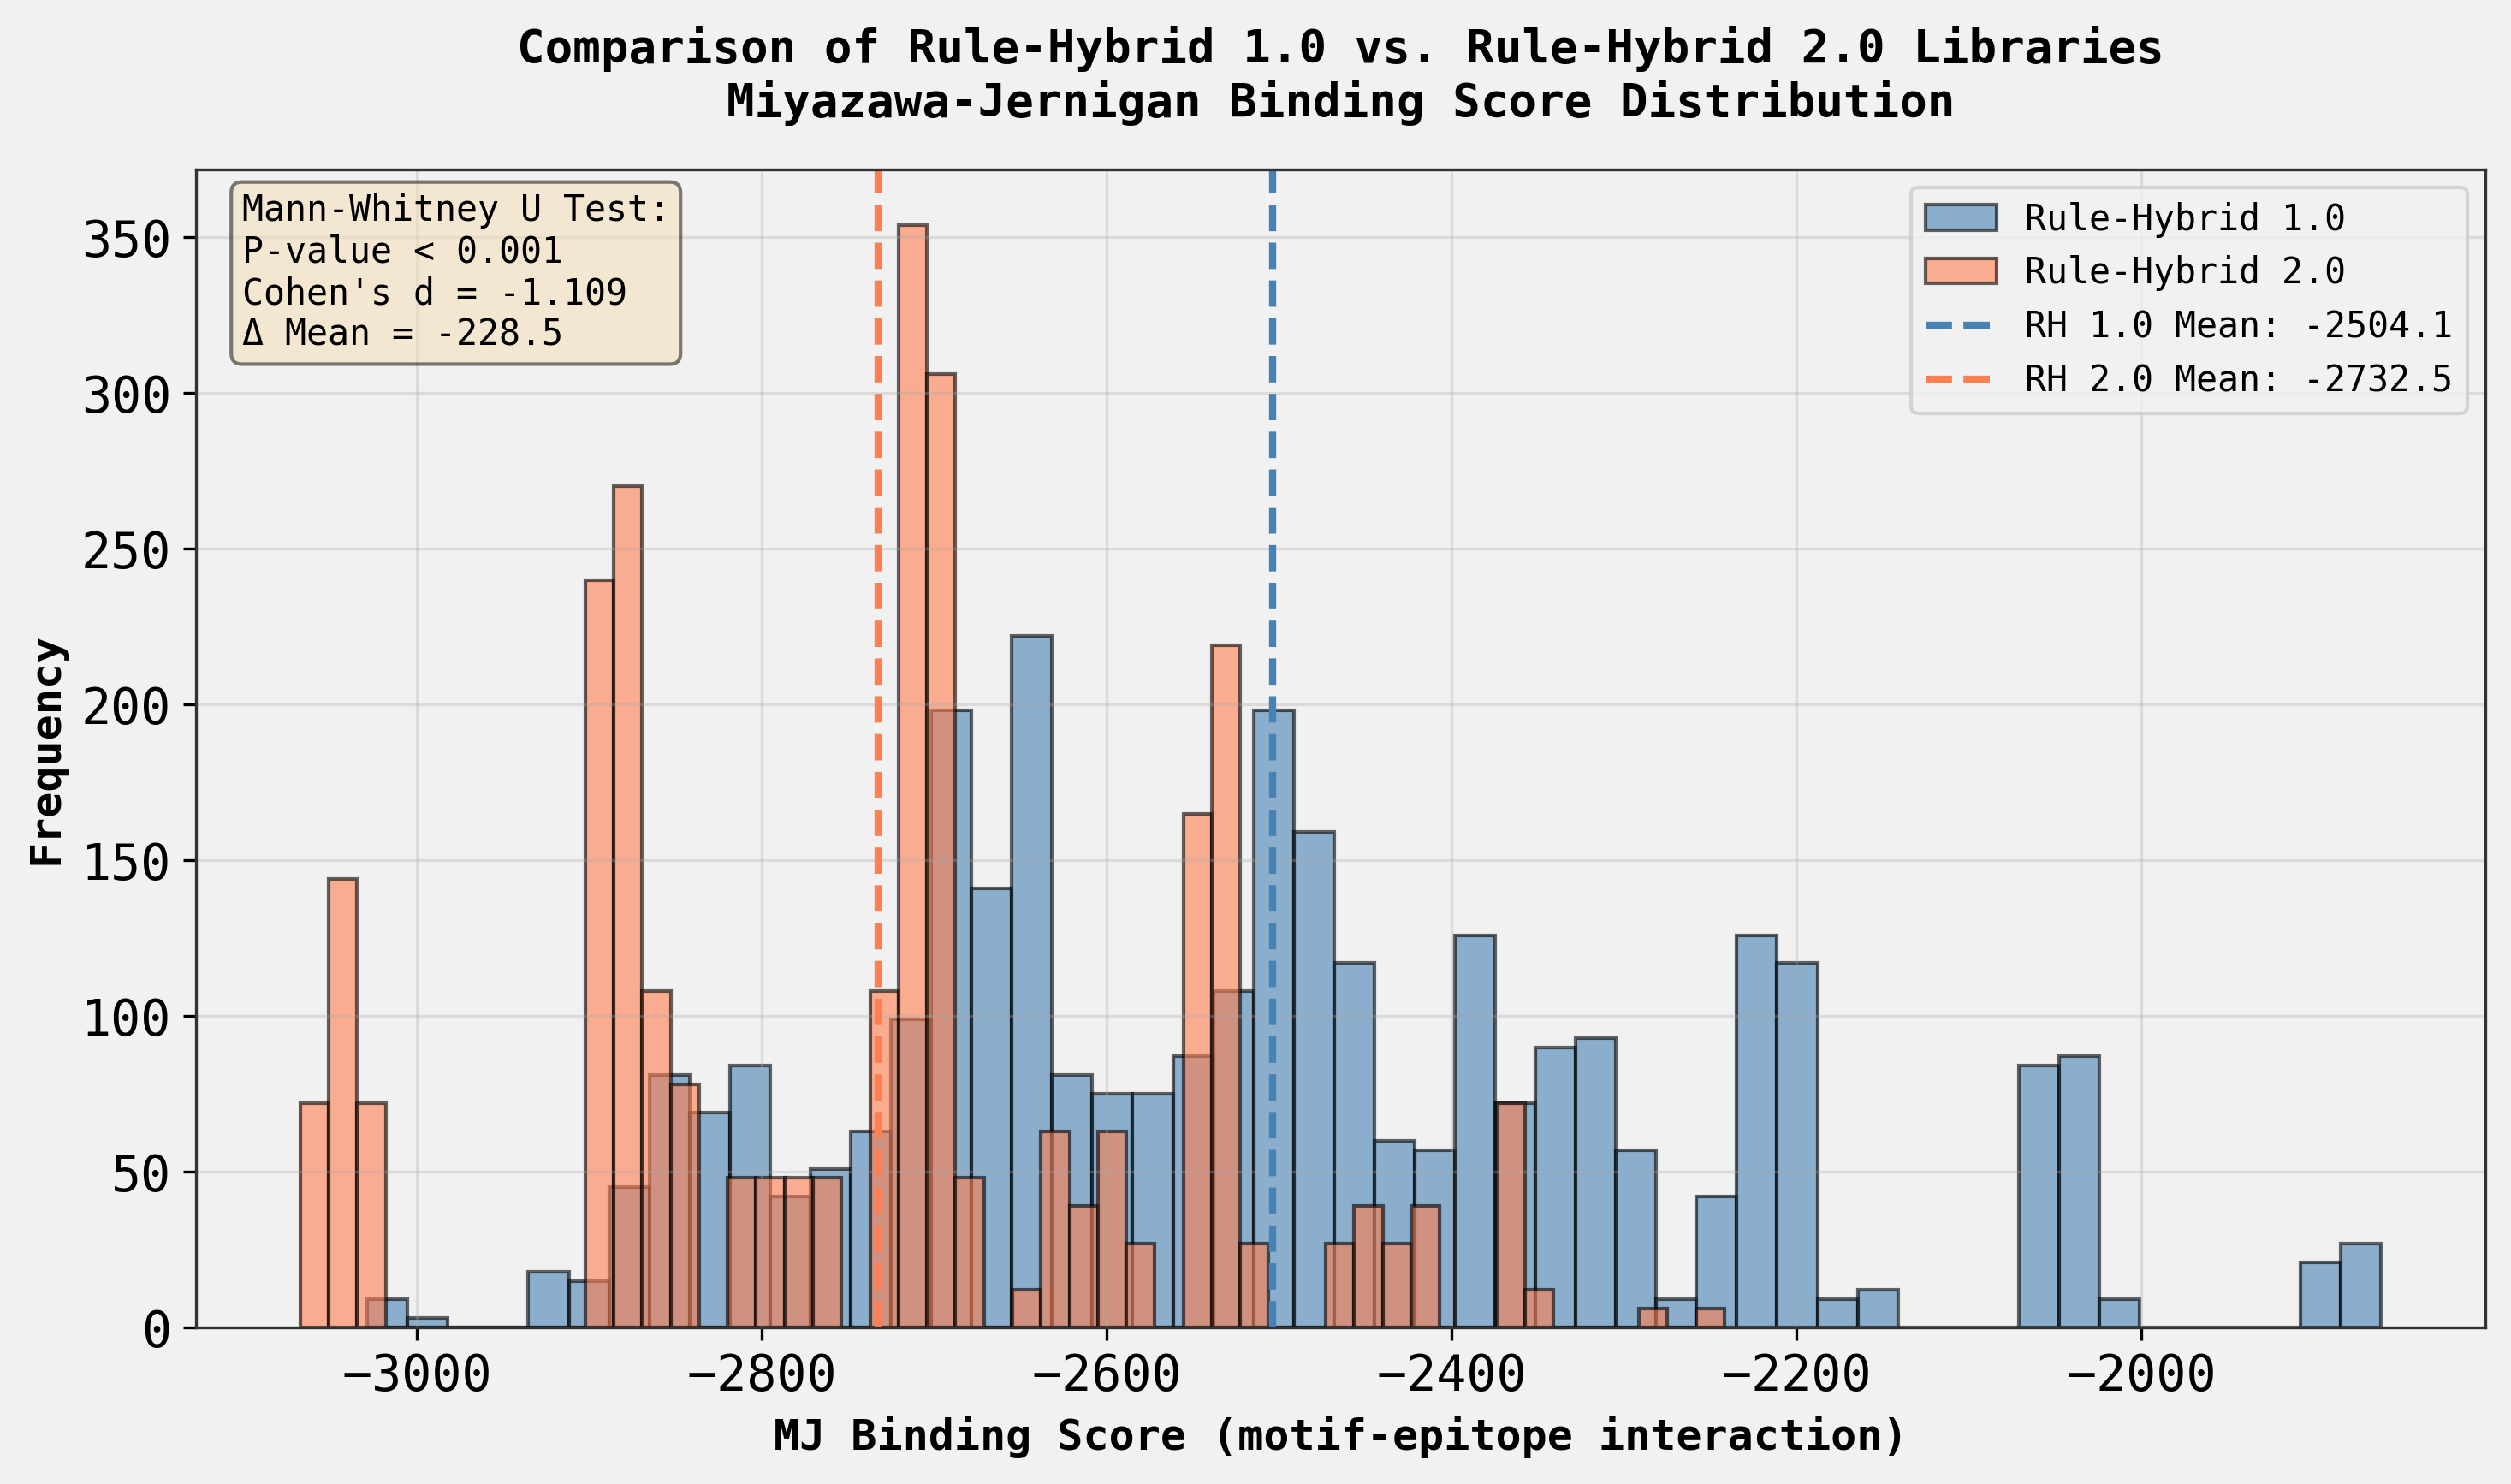


SUMMARY
Rule-Hybrid 2.0 shows a mean improvement of 228.46 units
This represents a 9.1% improvement in binding score
The improvement is statistically significant (p < 0.001)
The effect size is large (Cohen's d = -1.109)


In [ ]:

# Create a final summary visualization comparing the two libraries

import matplotlib.pyplot as plt

# Create a single figure with score distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create histograms
ax.hist(rh1_scores, bins=50, alpha=0.6, label='Rule-Hybrid 1.0', color='steelblue', edgecolor='black')
ax.hist(rh2_scores, bins=50, alpha=0.6, label='Rule-Hybrid 2.0', color='coral', edgecolor='black')

# Add mean lines
ax.axvline(rh1_mean, color='steelblue', linestyle='--', linewidth=2, label=f'RH 1.0 Mean: {rh1_mean:.1f}')
ax.axvline(rh2_mean, color='coral', linestyle='--', linewidth=2, label=f'RH 2.0 Mean: {rh2_mean:.1f}')

# Labels and formatting
ax.set_xlabel('MJ Binding Score (motif-epitope interaction)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Comparison of Rule-Hybrid 1.0 vs. Rule-Hybrid 2.0 Libraries\nMiyazawa-Jernigan Binding Score Distribution', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# Add statistical annotation
textstr = f'Mann-Whitney U Test:\nP-value < 0.001\nCohen\'s d = {cohens_d:.3f}\nΔ Mean = {improvement:.1f}'
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('rule_hybrid_comparison.png', dpi=300, bbox_inches='tight')
print("Figure saved as rule_hybrid_comparison.png")
plt.show()

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Rule-Hybrid 2.0 shows a mean improvement of {abs(improvement):.2f} units")
print(f"This represents a {abs(improvement)/abs(rh1_mean)*100:.1f}% improvement in binding score")
print(f"The improvement is statistically significant (p < 0.001)")
print(f"The effect size is large (Cohen's d = {cohens_d:.3f})")


In [ ]:

# Additional analysis: Compare the best designs from each library

print("="*70)
print("COMPARISON OF TOP DESIGNS")
print("="*70)

# Get top 10 from each library
rh1_top10 = rule_hybrid_df.groupby('Motif')['MJ_Score_Motif_Only'].first().sort_values().head(10)
rh2_top10 = novel_designs_df.groupby('Motif')['MJ_Score_Raw'].first().sort_values().head(10)

print("\nTop 10 motifs from Rule-Hybrid 1.0:")
for i, (motif, score) in enumerate(rh1_top10.items(), 1):
    print(f"{i:2d}. {motif}: {score:.2f}")

print("\nTop 10 motifs from Rule-Hybrid 2.0:")
for i, (motif, score) in enumerate(rh2_top10.items(), 1):
    # Find parent
    parent = novel_designs_df[novel_designs_df['Motif'] == motif]['Parent_Motif'].iloc[0]
    mutations = novel_designs_df[novel_designs_df['Motif'] == motif]['Mutations'].iloc[0]
    print(f"{i:2d}. {motif}: {score:.2f} (from {parent}, {mutations})")

# Compare best scores
rh1_best = rh1_top10.min()
rh2_best = rh2_top10.min()

print("\n" + "="*70)
print(f"Best RH 1.0 score: {rh1_best:.2f}")
print(f"Best RH 2.0 score: {rh2_best:.2f}")
print(f"Improvement in best score: {rh2_best - rh1_best:.2f} units ({abs(rh2_best - rh1_best)/abs(rh1_best)*100:.1f}%)")

# Check if any RH2.0 designs are better than the best RH1.0
n_better = (novel_designs_df['MJ_Score_Raw'] < rh1_best).sum()
print(f"\nNumber of RH 2.0 designs better than best RH 1.0: {n_better}")
print(f"Percentage of RH 2.0 library: {n_better/len(novel_designs_df)*100:.1f}%")


COMPARISON OF TOP DESIGNS

Top 10 motifs from Rule-Hybrid 1.0:
 1. LIIIILKLP: -3028.78
 2. LLIIILKLP: -3010.79
 3. LIILILKLP: -3010.79
 4. LLILILKLP: -2992.80
 5. LVIIILRLP: -2931.30
 6. LIIVILRLP: -2931.30
 7. LVIIILQLP: -2921.04
 8. LIIVILQLP: -2921.04
 9. LLIVILRLP: -2913.31
10. LVILILRLP: -2913.31

Top 10 motifs from Rule-Hybrid 2.0:
 1. VQCLVCIII: -3067.70 (from VQCLVCVVI, V7I,V8I)
 2. VQCVLCIII: -3067.70 (from VQCVLCVVI, V7I,V8I)
 3. VQCLICVII: -3067.70 (from VQCLVCVVI, V5I,V8I)
 4. VQCLICIVI: -3067.70 (from VQCLVCVVI, V5I,V7I)
 5. IQCVVCILI: -3067.70 (from VQCVVCVLI, V1I,V7I)
 6. IQCVVCLII: -3067.70 (from VQCVVCLVI, V1I,V8I)
 7. IQCVLCIVI: -3067.70 (from VQCVLCVVI, V1I,V7I)
 8. IQCVLCVII: -3067.70 (from VQCVLCVVI, V1I,V8I)
 9. IQCLVCVII: -3067.70 (from VQCLVCVVI, V1I,V8I)
10. IQCLVCIVI: -3067.70 (from VQCLVCVVI, V1I,V7I)

Best RH 1.0 score: -3028.78
Best RH 2.0 score: -3067.70
Improvement in best score: -38.92 units (1.3%)

Number of RH 2.0 designs better than best RH 1.0: 288
P